In [1]:
import numpy as np
import copy
from IPython.display import HTML
import matplotlib.pyplot as plt
import dill

import SimPEG as simpeg
from SimPEG.EM import NSEM
from pymatsolver import PardisoSolver
import telluricpy

# Set some matplotlib settings
%matplotlib inline


In [2]:
# Define the area of interest
bw, be = -250., 250
bs, bn = -250., 250.
bb, bt = -500.,0.

In [3]:
[botPadI[-i] for i in range(1,len(botPadI)+1)]

NameError: name 'botPadI' is not defined

In [4]:
botPadI

NameError: name 'botPadI' is not defined

In [5]:
mesh.vectorCCz

NameError: name 'mesh' is not defined

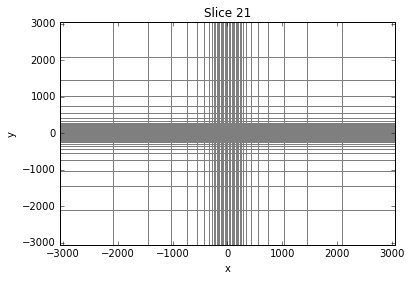

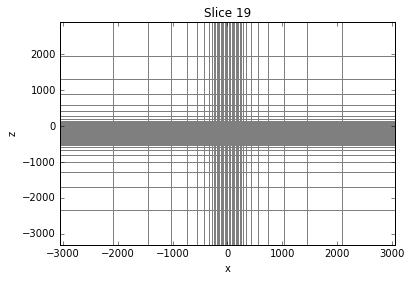

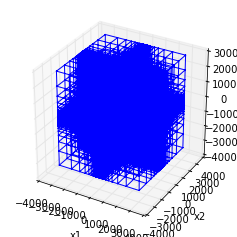

60648
186580


In [6]:
#Cell size
csx, csy, csz = 25.,25.,25.
# Number of core cells in each directiPon s
ncx, ncy, ncz = 20,20,24
# Number of padding cells to add in each direction
npad = 9
# Vectors of cell lengthts in each direction
hx = [(csx,npad, -1.5),(csx,ncx),(csx,npad, 1.5)]
hy = [(csy,npad, -1.5),(csy,ncy),(csy,npad, 1.5)]
hz = [(csz,npad,-1.5),(csz,ncz),(csy,npad, 1.5)]
#hz = [(csz,npad, -1.5),(csz,ncz),(csz,npad,1.5)]

# nrCcore = [6, 5, 4, 2, 2, 2, 2]
airPad = simpeg.Utils.meshTensor([(csz,npad,1.5)])
# vCore = np.concatenate([ np.ones(i)*s for i, s in zip(nrCcore,(simpeg.Utils.meshTensor([(csz,1),(csz,5,1.3)])))])[::-1]
# botPad = simpeg.Utils.meshTensor([(vCore[0],2,-1.5)])
# hz = np.concatenate((botPad,vCore,airPad))

# Create mesh
mesh = simpeg.Mesh.TensorMesh([hx, hy, hz],x0="CCN")
# Map mesh coordinates from local to UTM coordiantes
mesh.x0[2] = mesh.x0[2]+np.sum(airPad) + 100
#mesh.x0[2] = mesh.x0[2]- csz/2.#-np.max(mesh.vectorCCz[npad:-npad]) 

mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True)
mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True, normal="Y")
mesh.plotGrid()
plt.gca().set_aspect('equal')
plt.show()

print mesh.nC
print mesh.nF

In [7]:
mesh.vectorNz

array([-3308.25195312, -2347.16796875, -1706.4453125 , -1279.296875  ,
        -994.53125   ,  -804.6875    ,  -678.125     ,  -593.75      ,
        -537.5       ,  -500.        ,  -475.        ,  -450.        ,
        -425.        ,  -400.        ,  -375.        ,  -350.        ,
        -325.        ,  -300.        ,  -275.        ,  -250.        ,
        -225.        ,  -200.        ,  -175.        ,  -150.        ,
        -125.        ,  -100.        ,   -75.        ,   -50.        ,
         -25.        ,     0.        ,    25.        ,    50.        ,
          75.        ,   100.        ,   137.5       ,   193.75      ,
         278.125     ,   404.6875    ,   594.53125   ,   879.296875  ,
        1306.4453125 ,  1947.16796875,  2908.25195312])

In [8]:
sig_air = 1e-8
sphere_depth = 200.
sig_back = 1e-3
sig_sphere = 1e-1
sphere_r = 100.
sigma = sig_back*np.ones(mesh.nC)

#air cells
air = mesh.gridCC[:,2]>0.
sigma[air]=sig_air

#Define the sphere limit
inds = (np.sqrt((mesh.gridCC[:,2]+sphere_depth)**2.+(mesh.gridCC[:,1])**2.+(mesh.gridCC[:,0])**2.))< sphere_r
sigma[inds] = sig_sphere

# Get a 1D background model
bgsigma = mesh.r(sigma,'CC','CC','M')[0,0,:]

In [9]:
np.where(inds)

(array([25212, 25213, 25249, 25250, 25251, 25252, 25287, 25288, 25289,
        25290, 25326, 25327, 26617, 26618, 26619, 26620, 26654, 26655,
        26656, 26657, 26658, 26659, 26692, 26693, 26694, 26695, 26696,
        26697, 26730, 26731, 26732, 26733, 26734, 26735, 26768, 26769,
        26770, 26771, 26772, 26773, 26807, 26808, 26809, 26810, 28024,
        28025, 28060, 28061, 28062, 28063, 28064, 28065, 28098, 28099,
        28100, 28101, 28102, 28103, 28135, 28136, 28137, 28138, 28139,
        28140, 28141, 28142, 28173, 28174, 28175, 28176, 28177, 28178,
        28179, 28180, 28212, 28213, 28214, 28215, 28216, 28217, 28250,
        28251, 28252, 28253, 28254, 28255, 28290, 28291, 29467, 29468,
        29469, 29470, 29504, 29505, 29506, 29507, 29508, 29509, 29541,
        29542, 29543, 29544, 29545, 29546, 29547, 29548, 29579, 29580,
        29581, 29582, 29583, 29584, 29585, 29586, 29617, 29618, 29619,
        29620, 29621, 29622, 29623, 29624, 29655, 29656, 29657, 29658,
      

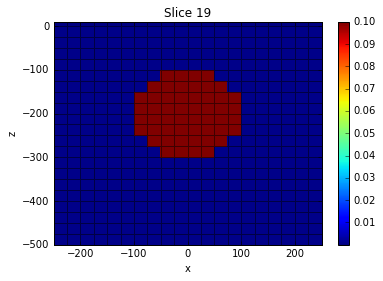

In [10]:
a = mesh.plotSlice(sigma, grid=True, normal="Y")
plt.gca().set_xlim([-250.,250])
plt.gca().set_ylim([-500.,10.])
plt.colorbar(a[0])

In [11]:
freqs = np.logspace(5,3,16)
print freqs

[ 100000.           73564.22544596   54116.95265465   39810.71705535
   29286.44564625   21544.34690032   15848.93192461   11659.1440118
    8576.95898591    6309.5734448     4641.58883361    3414.54887383
    2511.88643151    1847.84979742    1359.35639088    1000.        ]


In [12]:
print 500./np.sqrt(freqs*sig_back)

[  50.           58.29572006   67.96781954   79.24465962   92.39248987
  107.7217345   125.59432158  146.43222823  170.72744369  199.05358528
  232.07944168  270.58476327  315.47867224  367.82112723  428.8479493   500.        ]


In [27]:
# Make the rxLocations file
x,y,z = np.meshgrid(np.arange(-275,276,25),np.arange(-275,276,25),[0.])
locs = np.hstack((x.reshape(-1,1),y.reshape(-1,1),z.reshape(-1,1)))


In [28]:
locs

array([[-275., -275.,    0.],
       [-250., -275.,    0.],
       [-225., -275.,    0.],
       ..., 
       [ 225.,  275.,    0.],
       [ 250.,  275.,    0.],
       [ 275.,  275.,    0.]])

In [31]:
rxList = []        
for rx_orientation in ['xx', 'xy', 'yx', 'yy']:
    rxList.append(NSEM.Rx.Point_impedance3D(locs,rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_impedance3D(locs,rx_orientation, 'imag'))            
for rx_orientation in ['zx','zy']:
    rxList.append(NSEM.Rx.Point_tipper3D(locs,rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_tipper3D(locs,rx_orientation, 'imag'))
# Source list
srcList =[]
for freq in freqs:
    srcList.append(NSEM.Src.Planewave_xy_1Dprimary(rxList,freq))
# Survey MT
survey = NSEM.Survey(srcList)
# Background 1D model
sigma1d = mesh.r(sigma,'CC','CC','M')[0,0,:]
## Setup the problem object
problem = NSEM.Problem3D_ePrimSec(mesh, sigmaMap=simpeg.Maps.IdentityMap(), sigmaPrimary = sigma1d)
problem.verbose = True

problem.Solver = PardisoSolver
problem.pair(survey)

import time
## Calculate the fields
stTime = time.time()
print 'Starting calculating field solution at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
FmtSer = problem.fields(sigma)
print 'Ended calculation field at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

## Project data
stTime = time.time()
print 'Starting projecting fields to data at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
mtData = NSEM.Data(survey,survey.eval(FmtSer))
print 'Ended projection of fields at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

Starting calculating field solution at 2016-12-19 23:10:38
Starting work for 1.000e+03
Ran for 51.435318 seconds
Starting work for 1.359e+03
Ran for 55.051479 seconds
Starting work for 1.848e+03
Ran for 60.797866 seconds
Starting work for 2.512e+03
Ran for 59.507061 seconds
Starting work for 3.415e+03
Ran for 55.210892 seconds
Starting work for 4.642e+03
Ran for 55.390006 seconds
Starting work for 6.310e+03
Ran for 55.407121 seconds
Starting work for 8.577e+03
Ran for 57.855740 seconds
Starting work for 1.166e+04
Ran for 55.452650 seconds
Starting work for 1.585e+04
Ran for 54.774367 seconds
Starting work for 2.154e+04
Ran for 54.545253 seconds
Starting work for 2.929e+04
Ran for 58.801502 seconds
Starting work for 3.981e+04
Ran for 58.708853 seconds
Starting work for 5.412e+04
Ran for 65.308068 seconds
Starting work for 7.356e+04
Ran for 59.331392 seconds
Starting work for 1.000e+05
Ran for 63.265247 seconds
Ended calculation field at 2016-12-19 23:26:00
Ran for 921.784898
Starting pr

In [32]:
# Pickle the data
mtData.survey.unpair()

dill.dump(mtData,open('sphere_mtData.pklb','wb'))

In [2]:
mtData = dill.load(open('sphere_mtData.pklb','rb'))

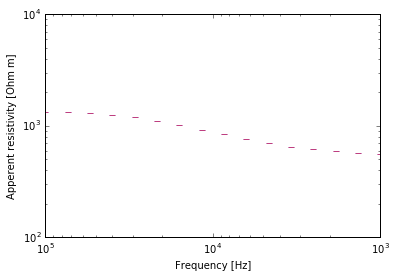

In [3]:
mtData.plot_app_res(np.array([0.,0.]))

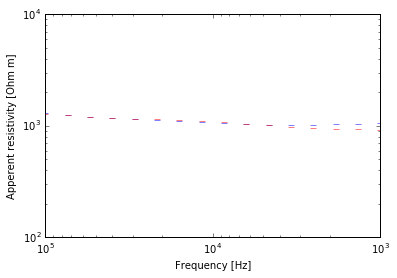

In [4]:
mtData.plot_app_res(np.array([-250.,0.]))

ValueError: x and y must be equal-length 1-D arrays

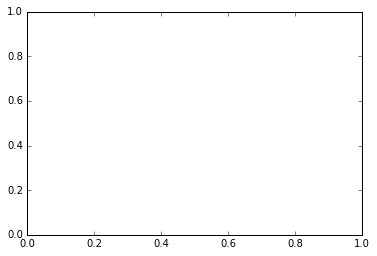